In [12]:
%load_ext autoreload
%autoreload 2
import concurrent.futures
import sys; sys.path.append('../')
import cv2 as cv
import pandas as pd
import os
import pickle
import numpy as np

from scipy.spatial.distance import cdist
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
JSON_EXT = ".json"
JPG_EXT = ".jpg"
train_set = r"../data/Ki67/SHIDC-B-Ki-67/Train"
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 120
color = {
        1:"brown",
        2:"blue",
        3:"green",
        4:"red"
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
data_path = "../data/Ki67/SHIDC-B-Ki-67/Train"
img_name= "p1_0299_6"

In [54]:

plt.imshow(img)

NameError: name 'img' is not defined

In [56]:
def sift_metric_keypointed(df,keypoints,radius=2,plot=False):
    df_results = df.copy()
    df_results['keypointed']=False
    df_results['keypointed_num']=0
    df_keys = list(zip(df.x,df.y))
    keypoints_results = pd.DataFrame(keypoints,columns={'x':[],'y':[]})
    keypoints_results['class']=4
    keypoints_results['labeled']=False
    keypoints_results['num_points']=0
    distances = cdist(df_keys,keypoints)
    for idx, keydf in enumerate(df_keys): #distance from each point loop dfpoints
        dist = distances[idx]
        for keypoint_idx, distance_to_dfnode in enumerate(dist): #loop over keypoints
            dfxy= (df_results.at[idx,'x'],df_results.at[idx,'y'])
            keyxy=(keypoints_results.at[keypoint_idx,'x'],keypoints_results.at[keypoint_idx,'y'])
           # print(dfxy,' to ', keyxy,
           #      ' dist ', cdist([dfxy],[keyxy]),' dist counted ', distance_to_dfnode, ' t ', cdist([dfxy],[keyxy])==distance_to_dfnode, ' min ', dist.min() )
            if distance_to_dfnode < radius:
                #print('small distnace ',distance_to_dfnode)
                label = df_results.at[idx,'label_id']
                df_results.at[idx,'keypointed']=True
                df_results.at[idx,'keypointed_num']+=1
                keypoints_results.at[keypoint_idx,'class']=label
                keypoints_results.at[keypoint_idx,'labeled']=True
                keypoints_results.at[keypoint_idx,'num_points']+=1
                
                if plot:
                    plt.plot([dfxy[0],keyxy[0]], [dfxy[1],keyxy[1]], marker='*', color=color[label])
                    plt.plot(keyxy[0], keyxy[1], marker='^', color=color[label],markersize=5)
                
    
    return df_results,keypoints_results

In [57]:
def sift_metric_research(df,keypoints,radius=2,plot=False,img_plot=None):
    if plot:
        plt.imshow(img_plot)
    res_df, res_key = sift_metric_keypointed(df,keypoints,radius,plot=plot)
    res_count=res_df.groupby(['keypointed'],as_index=False).count()
    negall = res_count.iloc[0].x/len(df)
    posall = res_count.iloc[1].x/len(df)
    
    num_count = res_key.groupby(['num_points'],as_index=False).count()
    
    res = {
        'all_df_points':len(df),
        'all_keypoints':len(keypoints),
        'negall':negall,
        'posall':posall,
        'good_keypoints':len(res_key[res_key['labeled']==True]),
        'bad_keypoints':len(res_key[res_key['labeled']==False]),
        'more_good_all_df':len(df)<len(res_key[res_key['labeled']==True]),
        'radius':radius,
    }
    if plot:
        plt.show()
    return res , res_df, res_key
    

In [58]:
img_path = os.path.join(str(data_path),str(img_name)+".jpg")
json_path = os.path.join(str(data_path),img_name+".json")
df = pd.read_json(json_path)
img = mpimg.imread(img_path)
sift = cv.SIFT_create()
keypoints, desc = sift.detectAndCompute(img,None)
kp = list(np.unique([key.pt for key in keypoints],axis=0))

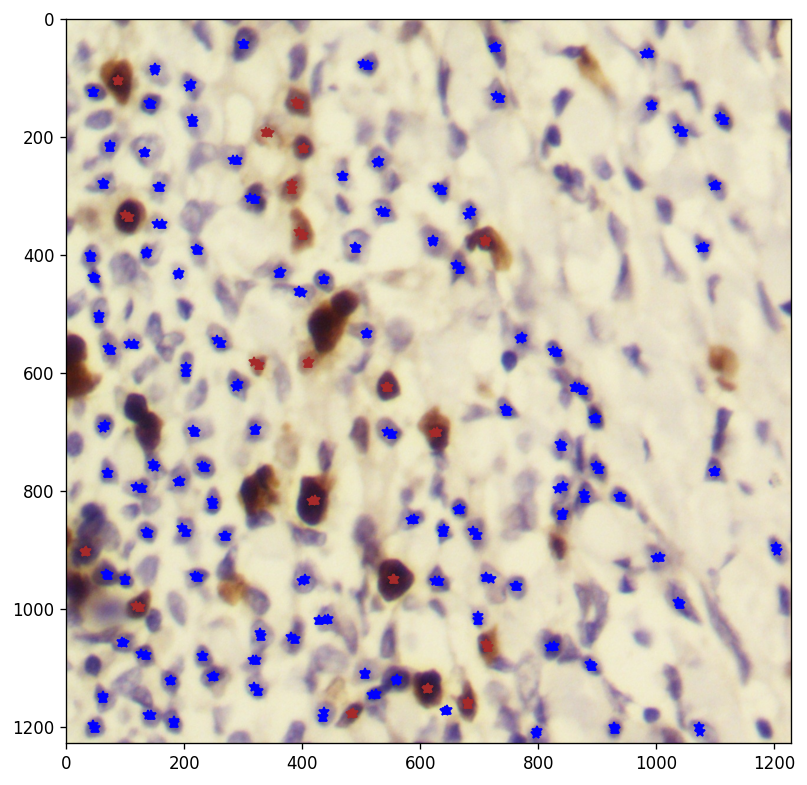

{'all_df_points': 184,
 'all_keypoints': 694,
 'negall': 0.29891304347826086,
 'posall': 0.7010869565217391,
 'good_keypoints': 131,
 'bad_keypoints': 563,
 'more_good_all_df': False,
 'radius': 10}

In [108]:
keys = []
res , res_df, res_key = sift_metric_research(df,kp,10,True,img)
res

In [ ]:
pd.DataFrame([res])

In [ ]:
for idx , row in df.iterrows():
    x = row[0]; y = row[1]; label = row[2]
    plt.plot(x, y, marker='*', color=color[label])
img=cv.drawKeypoints(img,keypoints,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

In [3]:
with open('results_p1_0299_6.pickle', 'rb') as handle:
    res = pickle.load(handle)

KeyboardInterrupt: 

In [20]:
pd.DataFrame([res_1])

,all_df_points,all_keypoints,negall,posall,good_keypoints,bad_keypoints,more_good_all_df,radius,sigma,octave,edge_limit,contrast,img_name
0,184,538,0.967391,0.032609,6,532,False,2,1.1,3,10,0.05,p1_0299_6


In [ ]:
os.getcwd()

In [2]:
final_res = pd.DataFrame()
final_df_res = pd.DataFrame()
final_key_res = pd.DataFrame()
bar = tqdm(total=1656)
for root, dirs, files in os.walk("../src/results", topdown=False):
    for name in files:
        if name.startswith('result'):    
            with open(os.path.join(root, name), 'rb') as handle:
                res = pickle.load(handle)
                for result in res:
                    if result is not None:
                        if result[0] is not None:
                            final_res=final_res.append(pd.DataFrame([result[0]]))
                            pass
                        if result[1] is not None:
                            #final_df_res=final_df_res.append(pd.DataFrame(result[1]))
                            pass
                        if result[2] is not None:
                            #final_key_res=final_key_res.append(pd.DataFrame(result[2]))
                            pass
            bar.update(1)

 33%|██████████████████████████▏                                                    | 549/1656 [10:54<34:06,  1.85s/it]

In [3]:
final_res.to_csv("final_fin_size.csv",index=False)


In [14]:
final_res=pd.read_csv('final_fin_size.csv')  

In [15]:
final_res

,all_df_points,all_keypoints,negall,posall,good_keypoints,bad_keypoints,more_good_all_df,radius,sigma,octave,edge_limit,contrast,img_name,size
0,72,3681,0.680556,0.319444,35,3646,False,5,1.3,30,30,0.01,p10_0031_5,8
1,72,1305,0.722222,0.277778,26,1279,False,5,1.3,30,30,0.01,p10_0031_5,18
2,72,673,0.722222,0.277778,26,647,False,5,1.3,30,30,0.01,p10_0031_5,28
3,72,314,0.736111,0.263889,21,293,False,5,1.3,30,30,0.01,p10_0031_5,38
4,72,216,0.777778,0.222222,16,200,False,5,1.3,30,30,0.01,p10_0031_5,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60912,62,196,0.887097,0.112903,7,189,False,8,1.3,40,30,0.02,p17_0189_3,58
60913,62,185,0.887097,0.112903,7,178,False,8,1.3,40,30,0.02,p17_0189_3,68
60914,62,102,0.935484,0.064516,4,98,False,8,1.3,40,30,0.02,p17_0189_3,78
60915,62,56,0.967742,0.032258,2,54,False,8,1.3,40,30,0.02,p17_0189_3,88


In [16]:
final_df_res.to_csv("final_df.csv",index=False)

In [17]:
final_key_res.to_csv("final_key.csv",index=False)

In [18]:
sift_params = ["radius","sigma","octave","edge_limit","contrast","size"]
final_res_n=final_res[final_res.more_good_all_df==False]

In [19]:
final_res

,all_df_points,all_keypoints,negall,posall,good_keypoints,bad_keypoints,more_good_all_df,radius,sigma,octave,edge_limit,contrast,img_name,size
0,72,3681,0.680556,0.319444,35,3646,False,5,1.3,30,30,0.01,p10_0031_5,8
1,72,1305,0.722222,0.277778,26,1279,False,5,1.3,30,30,0.01,p10_0031_5,18
2,72,673,0.722222,0.277778,26,647,False,5,1.3,30,30,0.01,p10_0031_5,28
3,72,314,0.736111,0.263889,21,293,False,5,1.3,30,30,0.01,p10_0031_5,38
4,72,216,0.777778,0.222222,16,200,False,5,1.3,30,30,0.01,p10_0031_5,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60912,62,196,0.887097,0.112903,7,189,False,8,1.3,40,30,0.02,p17_0189_3,58
60913,62,185,0.887097,0.112903,7,178,False,8,1.3,40,30,0.02,p17_0189_3,68
60914,62,102,0.935484,0.064516,4,98,False,8,1.3,40,30,0.02,p17_0189_3,78
60915,62,56,0.967742,0.032258,2,54,False,8,1.3,40,30,0.02,p17_0189_3,88


In [20]:
x=final_res.groupby(sift_params,as_index=False).mean().sort_values(by=["posall"],ascending=False).head(20)

In [21]:
len(final_res)

60917

In [22]:
final_res.sort_values(by=["posall"],ascending=False).head(20)

,all_df_points,all_keypoints,negall,posall,good_keypoints,bad_keypoints,more_good_all_df,radius,sigma,octave,edge_limit,contrast,img_name,size
23968,168,11103,0.023810,0.976190,412,10691,True,8,1.3,35,30,0.01,p13_0076_7,8
26175,32,4014,0.031250,0.968750,50,3964,True,8,1.3,35,30,0.02,p13_0095_5,8
26158,32,6930,0.031250,0.968750,59,6871,True,8,1.3,35,30,0.01,p13_0095_5,8
26141,32,3889,0.031250,0.968750,52,3837,True,8,1.3,30,30,0.02,p13_0095_5,8
26123,32,6514,0.031250,0.968750,60,6454,True,8,1.3,30,30,0.01,p13_0095_5,8
41374,28,3712,0.035714,0.964286,47,3665,True,8,1.3,30,30,0.01,p14_0086_11,8
24245,26,6954,0.038462,0.961538,55,6899,True,8,1.3,30,30,0.01,p13_0078_5,8
24345,26,4990,0.038462,0.961538,50,4940,True,8,1.3,40,30,0.02,p13_0078_5,8
24325,26,7752,0.038462,0.961538,58,7694,True,8,1.3,40,30,0.01,p13_0078_5,8
24265,26,4862,0.038462,0.961538,51,4811,True,8,1.3,30,30,0.02,p13_0078_5,8


In [27]:
corr = x[["negall","posall","radius","sigma","octave","edge_limit","contrast","size"]].corr()

<AxesSubplot:>

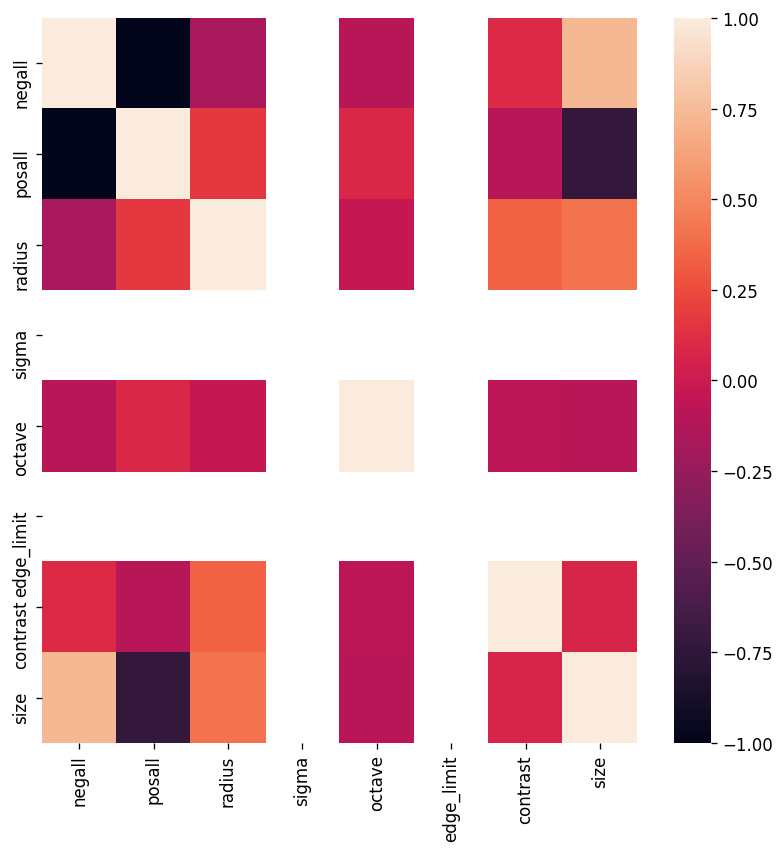

In [28]:
import seaborn as sns;
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [29]:
corr

,negall,posall,radius,sigma,octave,edge_limit,contrast,size
negall,1.000000,-1.000000,-0.167252,NaN,-0.092886,NaN,0.101310,0.726695
posall,-1.000000,1.000000,0.167252,NaN,0.092886,NaN,-0.101310,-0.726695
radius,-0.167252,0.167252,1.000000,NaN,-0.026103,NaN,0.342997,0.413670
sigma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
octave,-0.092886,0.092886,-0.026103,NaN,1.000000,NaN,-0.076102,-0.091782
edge_limit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contrast,0.101310,-0.101310,0.342997,NaN,-0.076102,NaN,1.000000,0.075378
size,0.726695,-0.726695,0.413670,NaN,-0.091782,NaN,0.075378,1.000000


In [105]:
list(range(8,9))

[8]

In [118]:
x=[1,2,3]

In [123]:
x[:-2]

[1]

In [131]:
bar = tqdm(total=1600)

  0%|                                                                                         | 0/1600 [00:00<?, ?it/s]

In [132]:
 bar.update(1)

  0%|                                                                               | 1/1600 [00:11<5:15:10, 11.83s/it]

True

In [41]:
print(x.drop(columns=['all_df_points','all_keypoints','good_keypoints','bad_keypoints','more_good_all_df',"negall"]).head(10).to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
 radius &  sigma &  octave &  edge\_limit &  contrast &  size &   posall \\
\midrule
      8 &    1.3 &      40 &          30 &      0.01 &     8 & 0.766339 \\
      8 &    1.3 &      35 &          30 &      0.01 &     8 & 0.755543 \\
      8 &    1.3 &      30 &          30 &      0.01 &     8 & 0.741823 \\
      8 &    1.3 &      35 &          30 &      0.02 &     8 & 0.621238 \\
      8 &    1.3 &      30 &          30 &      0.02 &     8 & 0.619957 \\
      8 &    1.3 &      40 &          30 &      0.02 &     8 & 0.614120 \\
      8 &    1.3 &      40 &          30 &      0.01 &    18 & 0.489608 \\
      5 &    1.3 &      40 &          30 &      0.01 &     8 & 0.487606 \\
      5 &    1.3 &      35 &          30 &      0.01 &     8 & 0.474380 \\
      8 &    1.3 &      35 &          30 &      0.01 &    18 & 0.474207 \\
\bottomrule
\end{tabular}



In [42]:
x=[1,2,3]

In [44]:
y=[[123],[23],[324]]

In [46]:
z=zip(x,y)

In [47]:
list(z)

[(1, [123]), (2, [23]), (3, [324])]

In [48]:
[z for z in zip(x,y) if z[0]==1]

[(1, [123])]